In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import re
import h5py
import scipy.io as spio
import scipy as sp

import sys
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()
from multiprocessing.dummy import Pool
import scipy.spatial.distance as dst
from scipy.stats import multivariate_normal
import scipy.optimize as op
import scipy as sp
sys.path.append('/home/yves/Documents/')
import twoptb as MP

kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)

## To-do list

<li>
insert 
</li>

#  Helper Functions

In [2]:



def calc_post_unNorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):
    """ calculate p(y|x;0)""" 
    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)
    
    L1 = np.dot(np.ones(n_neurons*nT),np.exp(A))
    L2 =  ybar.dot(A)
    L3 =  xbar.T.dot(K_bigInv.dot(xbar))
    p = L1 - L2 + L3 
    return p

def calc_post_grad(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):
    """ calculate dp(y|x;0)/dx"""
    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    dL1 = np.dot(np.exp(A),C_big)
    dL2 = np.dot(ybar, C_big)
    dL3 = np.dot(xbar.T,  K_bigInv)

    dL = dL1 - dL2 + dL3

    return np.squeeze(dL)


def calc_post_hess(xbar, ybar, C_big, d, K_bigInv,t,n_neurons):
    """ calculate dp(y|x;0)2/dx2"""
    nT = len(t)

    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    Aexpdiagonal = sp.sparse.spdiags(np.exp(A),0,n_neurons*nT,n_neurons*nT)
    temp = Aexpdiagonal.dot(C_big)

    ddL = np.dot(C_big.T, temp) +  K_bigInv
    return ddL

In [3]:
#### UTILITY FUNCTIONS FOR CONVERTING BETWEEN VECTOR AND MATRIX FORMS OF C AND d.
def make_vec_Cd(C,d):
    vecCd = np.vstack([C.T,d]).flatten()
    return vecCd


def makeCd_from_vec(vecCd,nDims,n_neurons):
    C = vecCd[:nDims*n_neurons].reshape(nDims,n_neurons).T
    d = vecCd[nDims*n_neurons:]
    return C,d



def Cd_obs_cost(vecCd,n_neurons,nDims,nT,y,x,postCov):
    """ Calculate the log-likelihood of parameters given observations current estimate 
        of the latent states and the obervations
        
        see "Estimating state and parameters in state space models of spike trains"
        Macke, Buesing and Sahani (2015) in Advanced State Space Methods for Neural
        and Clinical Data p149 """
    
    
    C,d = makeCd_from_vec(vecCd,nDims,n_neurons)
    C = C
    LL = 0
    for i in range(nT):
        t1 = C.dot(x[:,i]) + d
        t2 = .5*np.diag(C.dot(postCov[i]).dot(C.T))
        LL += y[:,i].dot(t1) - np.dot(np.ones(n_neurons),np.exp(t1+ t2))
    return -LL

def Cd_grad(vecCd,n_neurons,nDims,nT,y,x,postCov):
    
    C,d = makeCd_from_vec(vecCd,nDims,n_neurons)
    C_grad = np.zeros(C.shape)
    d_grad = np.zeros(d.shape)
    for i in range(nT):

        yhat = np.exp(C.dot(x[:,i]) + d + .5*np.diag(C.dot(postCov[i]).dot(C.T)))
        term2 = np.dot(np.diag(yhat),C.dot(postCov[i]))
        C_grad += np.dot(np.array([y[:,i]-yhat]).T,np.array([x[:,i]])) - term2
        d_grad += y[:,i] - yhat
    return -np.concatenate([C_grad.T.flatten(),d_grad])
    #int ar_grad

In [4]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.cdist(x,y)
    return dists

In [5]:
def calc_K(x,y=None,l=.5,add_offset=1e-3,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    cov = (1-add_offset)*np.exp(-.5*distsSq/(l**2)) 
    
    cov += np.eye(len(x))*add_offset
    return cov

In [6]:
def make_Cbig(C,t):
    return np.kron(np.eye(len(t)),C)

In [7]:
def make_Kbig(params,t,nDims,epsNoise=1e-3):

    epsSignal = (1-epsNoise)
    nT = len(t)  #number of time points
    #nDims = params['C'].shape[1] #dimensionality of the latent space
    #nT is
    K_big = np.zeros([nT*nDims,nT*nDims])  
    R_big = np.zeros([nT*nDims,nT*nDims]) 

    for dim in range(nDims):

        for t1_idx,t1 in enumerate(t):

            for t2_idx,t2 in enumerate(t):

                K_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = epsSignal*np.exp((-0.5)*((t1-t2)**2/(params['l'][dim])**2))
                R_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = 1
    return K_big, R_big


#  Ok now lets generate Poisson Data

In [8]:
n_neurons = 140 #q
nDims = 6
n_timePoints = 67
t = np.linspace(-33,33,num=n_timePoints)/10 #use this for an unmarked time series
nT = len(t)

sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(nDims)]



C = np.random.normal(loc=0,scale=.5,size=(n_neurons,nDims))
d = np.random.randint(0,6,size=(n_neurons))/2



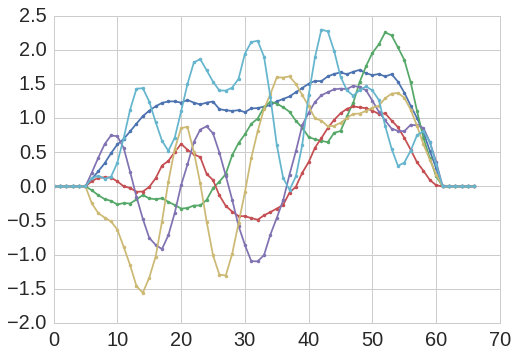

In [9]:
x = np.zeros([nDims,nT])

length_scales_GP = [10**(.1 if i== 0 else -i*.1) for i in range(nDims)]
params = {
          'l':length_scales_GP
         }
#params = [[4,1,2e0],
#          [1,2,1.5e-1],
#          [6,3,1e0]]

for i,l in enumerate(length_scales_GP):
    
    Ki = calc_K(x=t,y=t,l=l)
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[np.random.randint(1,5)-3]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=15)),np.ones(nT-35),np.cos(np.linspace(0,.5*np.pi,num=10)),np.zeros(5)])

for i in range(nDims):
    plt.plot(x[i],'.-')
    
#this is the observed data, which we pretend are the spike trains
rate_params = np.exp(C.dot(x) + d[:,None])
y = np.random.poisson(rate_params + np.abs(np.random.normal(loc=0,scale=1,size=rate_params.shape)))

In [10]:
true_params = {'C': C,
          'd': d,
          'l': length_scales_GP}

# Run EM

In [11]:
resLap.fun

NameError: name 'resLap' is not defined

In [12]:
st = time.time()
ybar = np.array([y.T.flatten()])

xSt = [] ;CdSt = []; Cst = []; dSt = []; tavSt = []
#C_init = np.random.normal(size = C.shape)
#d_init = np.random.normal(size =d.shape)
#xInit = np.random.normal(size = x.shape)

nT = len(t)
nDims = true_params['C'].shape[1]


C_init = np.random.normal(size = (n_neurons,nDims))
d_init = np.random.normal(size =n_neurons)
xInit = np.random.normal(size = (nDims,nT))
tavInit = np.random.normal(size = (nDims))

nDims = C_init.shape[1]


covSt = []
xSt.append(xInit); Cst.append(C_init); dSt.append(d_init); tavSt.append(tavInit)
K_big,_ = make_Kbig(params,t,nDims,epsNoise=1e-3)
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)
C_big = make_Cbig(Cst[-1],t)
xbar = np.array([xSt[-1].T.flatten()]).T

maxEMiter = 5
postLs = []
for i in range(maxEMiter):
    print i,
    ########################################################################
    ##############               E-Step                     ################
    ########################################################################
    
    K_big,_ = make_Kbig(params,t,nDims,epsNoise=1e-3)
    C_big = make_Cbig(Cst[-1],t)

    resLap = op.minimize(
        fun = calc_post_unNorm,
        x0 = xSt[-1],
        method='Newton-CG',
        args = (ybar, C_big, d, K_bigInv,t,n_neurons),
        jac = calc_post_grad,
        hess = calc_post_hess,
        options = {'disp': False,'maxiter': 500,'xtol':1e-16
        })


    x_post_mean = resLap.x.reshape(nDims,nT,order='F')
    postLs.append(resLap.fun)
    xSt.append(x_post_mean)
    xbar = np.array([xSt[-1].T.flatten()]).T


    hess = calc_post_hess(resLap.x,  ybar, C_big, d, K_bigInv,t,n_neurons)
    PostCovGP = np.linalg.inv(hess)
    covSt.append(PostCovGP)
    #PostCovGP = PostCovGP
    PostCovOther  = np.zeros(PostCovGP.shape)

    for dim1 in range(nDims):
        for dim2 in range(nDims):
            PostCovOther[dim1*nT:(dim1+1)*nT,dim2*nT:(dim2+1)*nT] = PostCovGP[dim1::nDims,dim2::nDims]

    #here calculate the covariance matrix
    cov_store = np.zeros([nT,nDims,nDims])
    for kk in range(nT):
        cov_store[kk][:,:] = PostCovOther[kk::nT,kk::nT]

    covSt.append(PostCovOther)
    ########################################################################
    ##############               M-Step                     ################
    ########################################################################

    
    
    ##############      Infer Parameters C and d            ################
    T = nT
    vecCd = make_vec_Cd(Cst[-1], dSt[-1])

    resCd = op.minimize(
                    fun = Cd_obs_cost,
                    x0 = vecCd,
                    args = (n_neurons,nDims,nT,y,xSt[-1],cov_store),
                    jac = Cd_grad,
                    method = 'TNC',
                    options = {'disp': False, 'maxiter':500,'ftol':1e-16,'gtol':1e-16,'xtol':1e-16}
                    )

    
    C_inf,d_inf = makeCd_from_vec(resCd.x,nDims,n_neurons)
    Cst.append(C_inf); dSt.append(d_inf)
    
    ##############      Infer Parameter tav for GP            ##############
    precomp = makePrecomp(infRes)
        for xd in range(xdim): 
            initp = np.log(1/oldTau[xd]**2)


            res = op.minimize(
                fun = tav_cost,
                x0 = initp,
                args = (precomp[xd], 0.001),
                jac = tav_grad,
                options = {'disp': False,'gtol':1e-8})
            pOptimizeDetails[xd] = res
            tempTau[xd] = (1/np.exp(res.x))**(0.5)
print time.time() - st

0 1 2 3 4 48.6286849976


In [ ]:
x_post_mean.T.dot(np.linalg.inv())

#  Infer the timescales

In [25]:
# for tau

def makePrecomp(infRes):
    '''
    Function written by Byron & Yu 2009 for the GPFA model. 
    The timescale constant cost function is exactly the same as the P-GPFA case. 
    Translated to Python by Hooram Nam 2015
    '''
    xdim, T = np.shape(infRes['post_mean'][0])
    numTrials = len(infRes['post_mean'])

    Ttile1=np.tile(np.asarray([np.arange(T)]).T,[1,T])+1
    Ttile2=np.tile(np.asarray([np.arange(T)]),[T,1])+1
    Tdif = Ttile1-Ttile2
    difSq = Tdif*Tdif

    precomp = []
    PautoSum = []

    for xd in range(xdim):
        tempPautoSum = np.zeros([T,T])
        for tr in range(numTrials):
            tempPautoSum = tempPautoSum + infRes['post_vsmGP'][tr][:,:,xd] + np.outer(infRes['post_mean'][tr][xd,:],infRes['post_mean'][tr][xd,:])

        precomp.append({
            'T':T, 
            'Tdif':Tdif, 
            'difSq':difSq, 
            'numTrials':numTrials,
            'PautoSum':tempPautoSum})
    return precomp

def MStepGPtimescaleCost(p, precomp, epsNoise):
    '''
    Function written by Byron & Yu 2009 for the GPFA model. 
    The timescale constant cost function is exactly the same in the P-GPFA case. 
    Translated to Python by Hooram Nam 2015
    '''
    T = precomp['T']

    temp = (1-epsNoise)*np.exp(-np.exp(p)/2*precomp['difSq'])
    K = temp + epsNoise*np.eye(T)
    dKdgamma = -0.5*temp*precomp['difSq']
    
    dEdgamma = 0
    f = 0

    Thalf = int(np.ceil(T/2))
    Kinv = np.linalg.inv(K)
    sign, logdet = np.linalg.slogdet(K)
    logdet_K = sign*logdet

    KinvM = np.dot(Kinv[:Thalf,:],dKdgamma)
    KinvMKinv = np.dot(KinvM,Kinv)
    
    dg_KinvM = np.diag(KinvM)
    tr_KinvM = 2*sum(dg_KinvM) - T%2*dg_KinvM[-1]

    mkr = int(np.ceil(0.5*T**2))

    KinvVec = np.reshape(Kinv,T*T)
    PSallVec = np.reshape(precomp['PautoSum'],T*T)
    PS1vec = PSallVec[:mkr]
    PS2vec = PSallVec[mkr:]
    PS2vec = PS2vec[::-1]

    KinvMKinvVec = np.reshape(KinvMKinv, mkr)
    
    dEdgamma = -0.5*precomp['numTrials']*tr_KinvM + 0.5*np.dot(PS1vec,KinvMKinvVec)+ 0.5*np.dot(PS2vec,KinvMKinvVec)
    f = -0.5* precomp['numTrials']*logdet_K - 0.5*np.dot(PSallVec,KinvVec)

    return -f



def learnGPparams(oldParams, infRes, experiment):
    xdim, T = np.shape(infRes['post_mean'][0])
    binSize = experiment.binSize
    oldTau = oldParams['tau']*1000/binSize
    
    precomp = makePrecomp(infRes)
    
    tempTau = np.zeros(xdim)

    pOptimizeDetails = [[]]*xdim
    for xd in range(xdim): 
        initp = np.log(1/oldTau[xd]**2)


        res = op.minimize(
            fun = MStepGPtimescaleCost,
            x0 = initp,
            args = (precomp[xd], 0.001),
            jac = MStepGPtimescaleCost_grad,
            options = {'disp': False,'gtol':1e-8})
        pOptimizeDetails[xd] = res
        tempTau[xd] = (1/np.exp(res.x))**(0.5)

newTau = tempTau*binSize/1000

NameError: name 'tempTau' is not defined

In [ ]:
def MStepGPtimescaleCost_grad(p, precomp, epsNoise):
    '''
    Function written by Byron, Yu in 2009 for the GPFA model. 
    The timescale constant cost function is exactly the same in the P-GPFA case. 
    Translated to Python by Hooram Nam 2015
    '''
    T = precomp['T']
    
    temp = (1-epsNoise)*np.exp(-np.exp(p)/2*precomp['difSq'])
    K = temp + epsNoise*np.eye(T)
    dKdgamma = -0.5*temp*precomp['difSq']
    
    dEdgamma = 0
    f = 0

    Thalf = int(np.ceil(T/2))
    Kinv = np.linalg.inv(K)
    sign, logdet = np.linalg.slogdet(K)
    logdet_K = sign*logdet

    KinvM = np.dot(Kinv[:Thalf,:],dKdgamma)
    KinvMKinv = np.dot(KinvM,Kinv)
    
    dg_KinvM = np.diag(KinvM)
    tr_KinvM = 2*sum(dg_KinvM) - T%2*dg_KinvM[-1]

    mkr = int(np.floor(0.5*T**2))

    KinvVec = np.reshape(Kinv,T*T)
    PSallVec = np.reshape(precomp['PautoSum'],T*T)
    PS1vec = PSallVec[:mkr]
    PS2vec = PSallVec[mkr:]
    PS2vec = PS2vec[::-1]

    KinvMKinvVec = np.reshape(KinvMKinv, mkr)
    
    dEdgamma = -0.5*precomp['numTrials']*tr_KinvM + 0.5*np.dot(PS1vec,KinvMKinvVec) + 0.5*np.dot(PS2vec,KinvMKinvVec)
    f = -0.5* precomp['numTrials']*logdet_K - 0.5*np.dot(PSallVec,KinvVec)

    return -dEdgamma*np.exp(p)

# Plotting

In [13]:
U,D,V = sp.linalg.svd(Cst[-1])
xSVD = (np.dot(np.diag(D),V.T).dot(xSt[-1]))

In [14]:
U,D,V = sp.linalg.svd(C)
xSVD_true = (np.dot(np.diag(D),V.T).dot(x))

###  Look at Posterior Likelihood

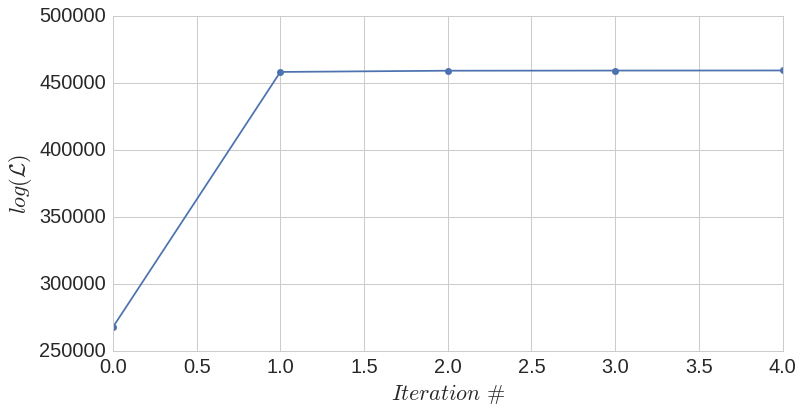

In [15]:
plt.figure(figsize=(12,6))
plt.plot(-np.array(postLs),marker='o')
plt.xlabel(r'$Iteration \ \#$')
plt.ylabel(r'$log(\mathcal{L})$')

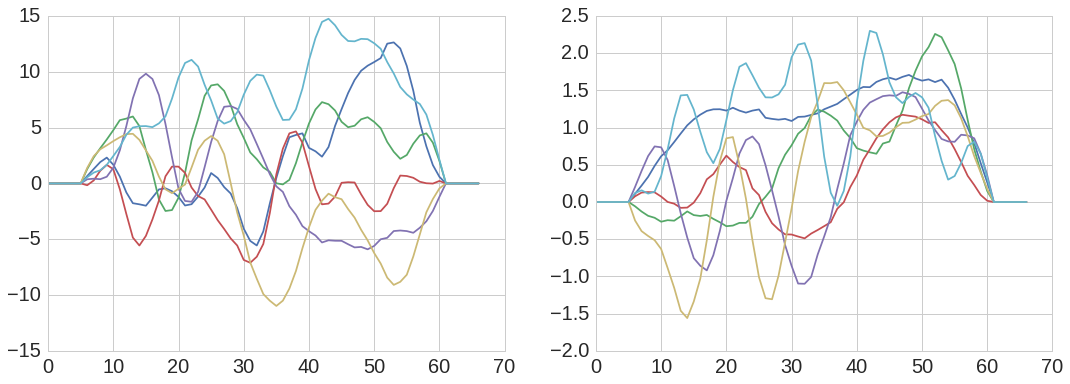

In [16]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
for i in xSVD_true:
    plt.plot(i)
    
plt.subplot(1,2,2)
for i in x:
    plt.plot(i)
    

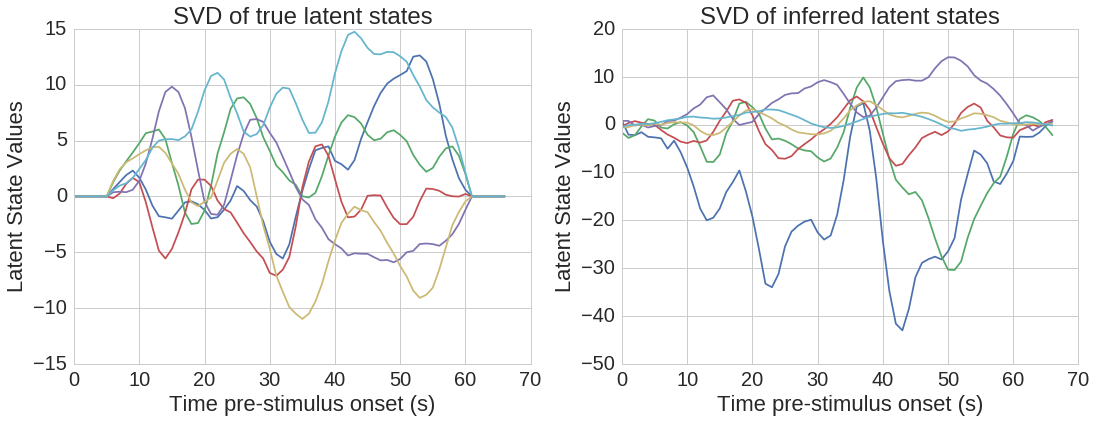

In [17]:
## Plot the SVD of the inferred and ground truth latent state trajectories
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.title('SVD of true latent states')
for i in xSVD_true:
    plt.plot(i)
    plt.xlabel('Time pre-stimulus onset (s)')
    plt.ylabel('Latent State Values')
    
    
plt.subplot(1,2,2)
plt.title('SVD of inferred latent states')
for i in xSVD:
    plt.plot(i)
    plt.xlabel('Time pre-stimulus onset (s)')
    plt.ylabel('Latent State Values')

    

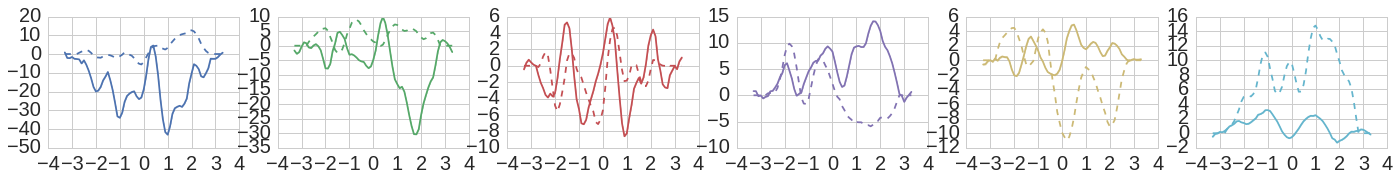

In [18]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)
SD2 = 2*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))

i = 0
for lapInf,gT in zip(xSVD,xSVD_true):
    plt.subplot(3,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    


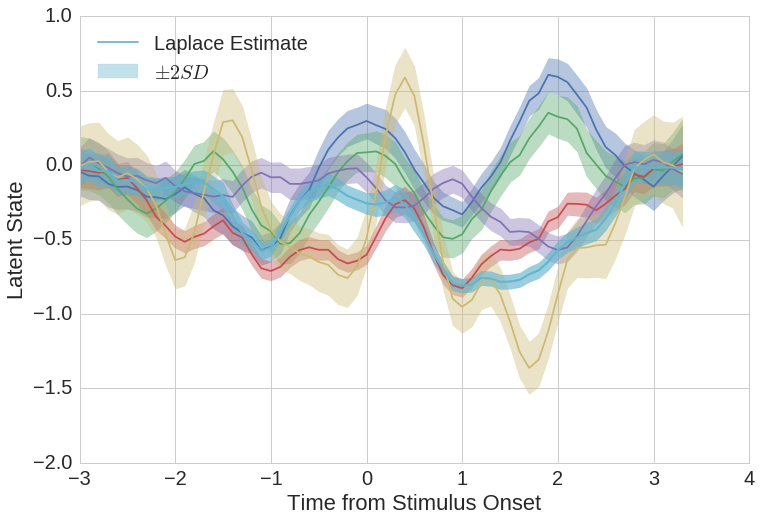

In [19]:
plt.figure(figsize=(12,8))
clrs = seaborn.color_palette('deep',n_colors=nDims+1,desat=1)#seaborn.color_palette('RdBu',n_colors=3)
SD2 = 6*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))
i = 0
for lapInf,gT in zip(xSt[-1],x):
    
    
    plt.plot(t,lapInf,color=clrs[i])
    #plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    
plt.plot(t,lapInf,color=clrs[i-1],label='Laplace Estimate')
#plt.plot(t,gT,linestyle='--',color=clrs[i-1],label='Ground Truth')
plt.fill_between(t,lapInf + SD2[i-1],lapInf - SD2[i-1],color=clrs[i-1],alpha=.4,label=r'$\pm2SD$')

plt.ylabel('Latent State')
plt.xlabel('Time from Stimulus Onset')
plt.xlim(-3,)
plt.legend(loc='best')

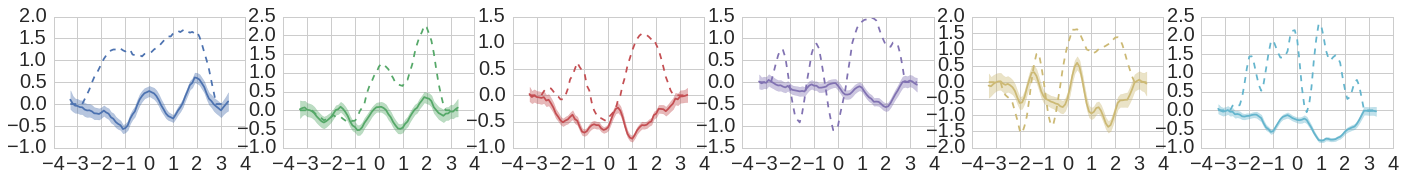

In [20]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(xSt[5],x):
    plt.subplot(3,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    


In [21]:
lim = np.max(covSt[-1])

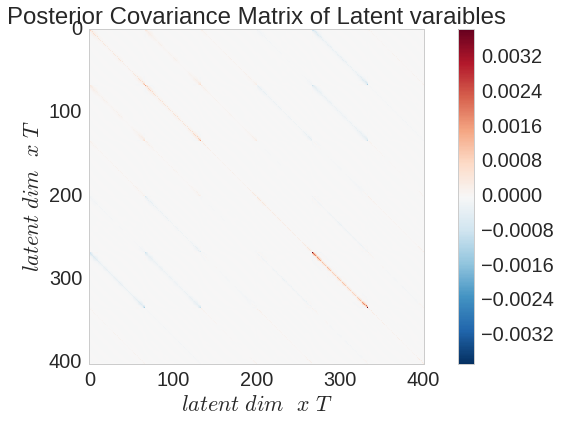

In [22]:
plt.figure(figsize=(12,6))
plt.title('Posterior Covariance Matrix of Latent varaibles')
plt.imshow(covSt[-1],vmax=lim,vmin=-lim,
                     cmap='RdBu_r',interpolation='None')
plt.xlabel(r'$latent \ dim \ \ x \ T$')
plt.ylabel(r'$latent \ dim \ \ x \ T$')

plt.grid()
plt.colorbar()

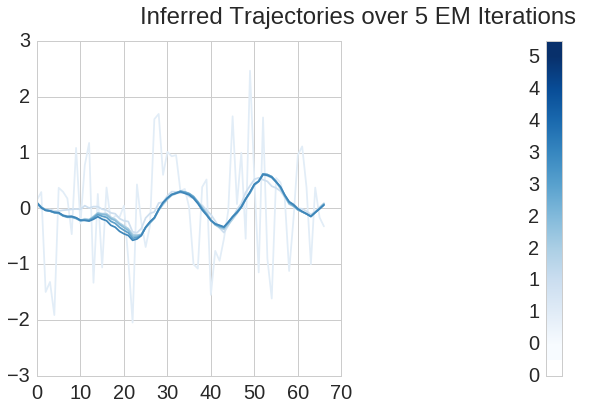

In [23]:
clrs = seaborn.color_palette('Blues',n_colors=int(2+len(xSt)/1),desat=.9)
plt.figure(figsize=(12,6))
plt.suptitle('Inferred Trajectories over %s EM Iterations \n' %maxEMiter)

plt.subplot(1,2,1)
for  i,xs in enumerate(xSt[0::1]):
    plt.plot(xs[0],color=clrs[i],alpha=1)
    
plt.subplot(1,2,2)
plt.imshow(np.flipud(np.array([range(10)]).T),aspect=2,cmap='Blues')
plt.xticks([])
plt.yticks(np.linspace(0,10,num=11),np.linspace(maxEMiter,0,num=11).astype('int'))
plt.grid()

## Plot Firing Rates

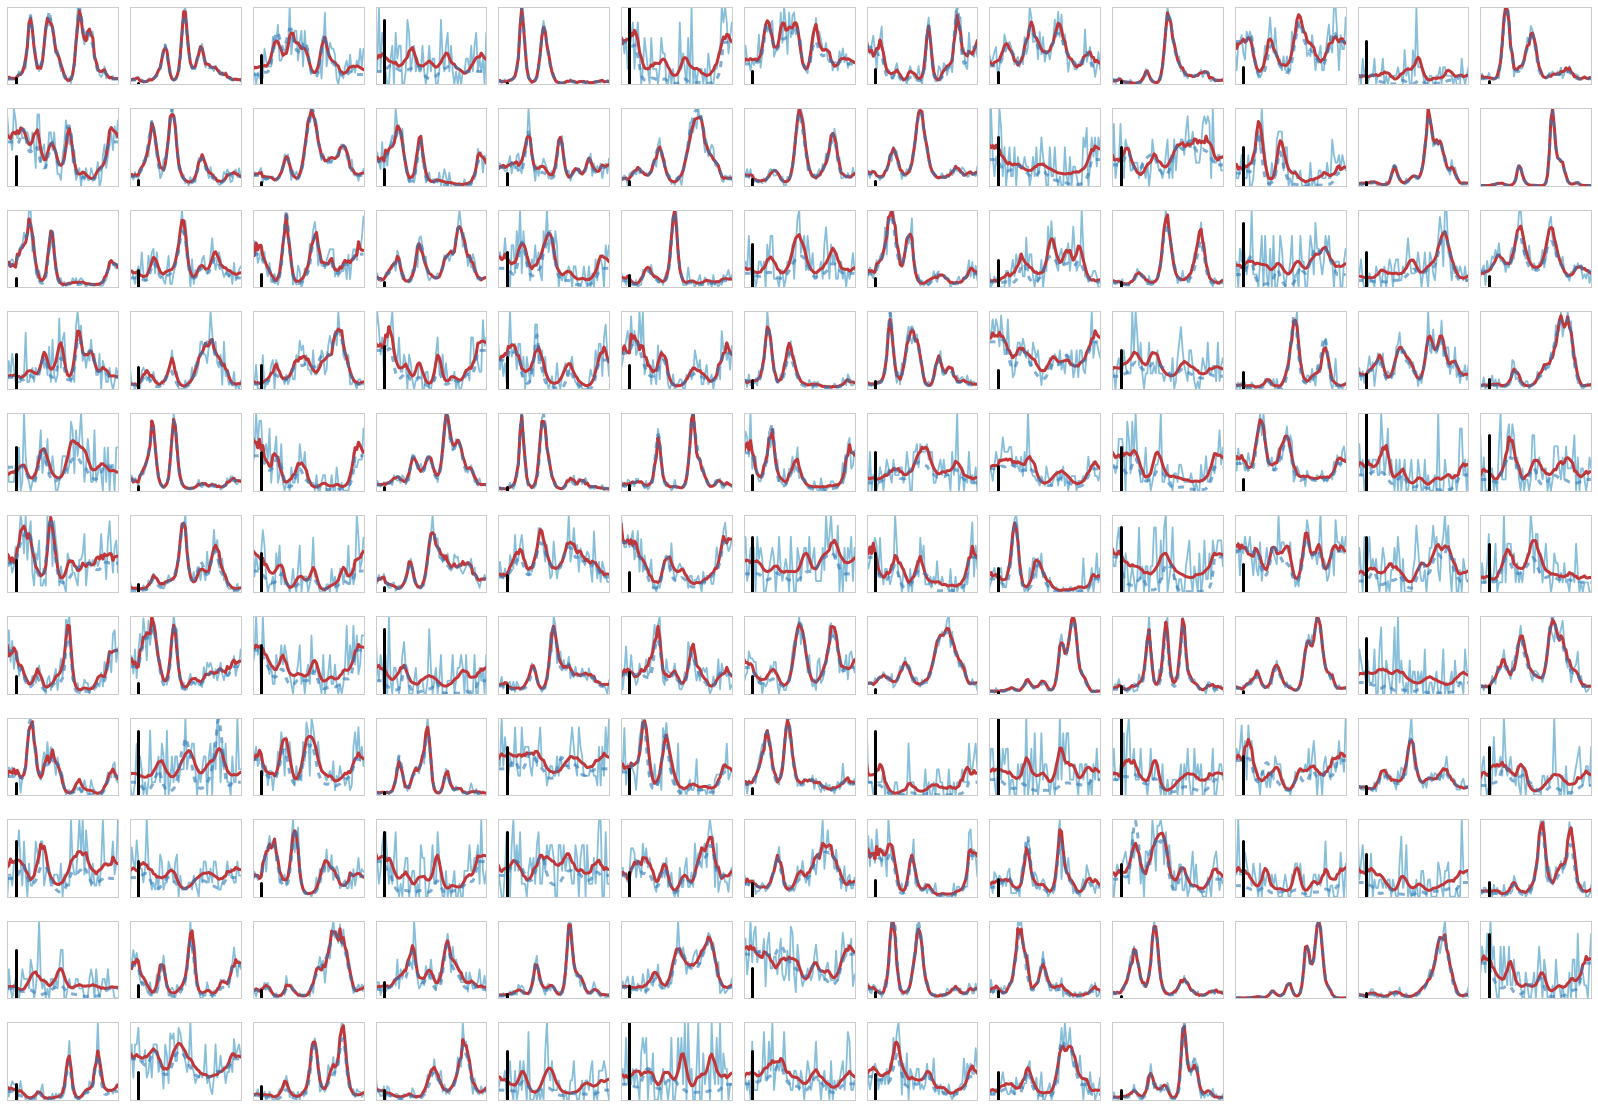

In [24]:
plt.figure(figsize=(22,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
#plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= np.ceil(np.sqrt(n_neurons))+1,np.ceil(np.sqrt(n_neurons))+1

tt = 0

idx = 5
for real,sim in zip(np.exp(C.dot(x).T+d).T,
                    np.exp(Cst[idx].dot(xSt[idx]).T+dSt[idx]).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(sim,color=clrs[0],linewidth=3)
        plt.plot(real,'--',color=clrs[-1],linewidth=3,alpha=0.6)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        plt.plot([5,5],[0,5],linewidth=3,color='k')
        #plt.legend()
        
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)
